In [1]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('/home/t-jiaweiwang/Project/GOT-OCR2.0-HDSA/outputs/POD-DocLayNet-wo-others-3e-unfreeze-backbone-stage2', trust_remote_code=True)
model = AutoModel.from_pretrained('/home/t-jiaweiwang/Project/GOT-OCR2.0-HDSA/outputs/POD-DocLayNet-wo-others-3e-unfreeze-backbone-stage2', trust_remote_code=True, low_cpu_mem_usage=True, device_map='cuda', use_safetensors=True, pad_token_id=tokenizer.eos_token_id, output_hidden_states=True, output_attentions=True, return_dict=True, attn_implementation="eager")
model = model.eval().cuda()

/home/t-jiaweiwang/miniconda3/envs/got/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn.functional as F
from typing import Optional, Tuple, Type
from functools import partial
import torch.nn as nn
from typing import Type



class MLPBlock(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        mlp_dim: int,
        act: Type[nn.Module] = nn.GELU,
    ) -> None:
        super().__init__()
        self.lin1 = nn.Linear(embedding_dim, mlp_dim)
        self.lin2 = nn.Linear(mlp_dim, embedding_dim)
        self.act = act()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.lin2(self.act(self.lin1(x)))



class LayerNorm2d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-6) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight[:, None, None] * x + self.bias[:, None, None]
        return x



class ImageEncoderViT(nn.Module):
    def __init__(
        self,
        img_size: int = 1024,
        patch_size: int = 16,
        in_chans: int = 3,
        embed_dim: int = 768,
        depth: int = 12,
        num_heads: int = 12,
        mlp_ratio: float = 4.0,
        out_chans: int = 256,
        qkv_bias: bool = True,
        norm_layer: Type[nn.Module] = nn.LayerNorm,
        act_layer: Type[nn.Module] = nn.GELU,
        use_abs_pos: bool = True,
        use_rel_pos: bool = False,
        rel_pos_zero_init: bool = True,
        window_size: int = 0,
        global_attn_indexes: Tuple[int, ...] = (),
    ) -> None:
        """
        Args:
            img_size (int): Input image size.
            patch_size (int): Patch size.
            in_chans (int): Number of input image channels.
            embed_dim (int): Patch embedding dimension.
            depth (int): Depth of ViT.
            num_heads (int): Number of attention heads in each ViT block.
            mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
            qkv_bias (bool): If True, add a learnable bias to query, key, value.
            norm_layer (nn.Module): Normalization layer.
            act_layer (nn.Module): Activation layer.
            use_abs_pos (bool): If True, use absolute positional embeddings.
            use_rel_pos (bool): If True, add relative positional embeddings to the attention map.
            rel_pos_zero_init (bool): If True, zero initialize relative positional parameters.
            window_size (int): Window size for window attention blocks.
            global_attn_indexes (list): Indexes for blocks using global attention.
        """
        super().__init__()
        self.img_size = img_size

        self.patch_embed = PatchEmbed(
            kernel_size=(patch_size, patch_size),
            stride=(patch_size, patch_size),
            in_chans=in_chans,
            embed_dim=embed_dim,
        )

        self.pos_embed: Optional[nn.Parameter] = None
        if use_abs_pos:
            # Initialize absolute positional embedding with pretrain image size.
            self.pos_embed = nn.Parameter(
                torch.zeros(1, img_size // patch_size, img_size // patch_size, embed_dim)
            )

        self.blocks = nn.ModuleList()
        for i in range(depth):
            block = Block(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                norm_layer=norm_layer,
                act_layer=act_layer,
                use_rel_pos=use_rel_pos,
                rel_pos_zero_init=rel_pos_zero_init,
                window_size=window_size if i not in global_attn_indexes else 0,
                input_size=(img_size // patch_size, img_size // patch_size),
            )
            self.blocks.append(block)

        self.neck = nn.Sequential(
            nn.Conv2d(
                embed_dim,
                out_chans,
                kernel_size=1,
                bias=False,
            ),
            LayerNorm2d(out_chans),
            nn.Conv2d(
                out_chans,
                out_chans,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            LayerNorm2d(out_chans),
        )

        
        self.net_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False)
        self.net_3 = nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.patch_embed(x)
        if self.pos_embed is not None:
            x = x + self.pos_embed

        for blk in self.blocks:
            x = blk(x)

        x = self.neck(x.permute(0, 3, 1, 2))
        x = self.net_2(x)
        x = self.net_3(x)


        return x


class Block(nn.Module):
    """Transformer blocks with support of window attention and residual propagation blocks"""

    def __init__(
        self,
        dim: int,
        num_heads: int,
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        norm_layer: Type[nn.Module] = nn.LayerNorm,
        act_layer: Type[nn.Module] = nn.GELU,
        use_rel_pos: bool = False,
        rel_pos_zero_init: bool = True,
        window_size: int = 0,
        input_size: Optional[Tuple[int, int]] = None,
    ) -> None:
        """
        Args:
            dim (int): Number of input channels.
            num_heads (int): Number of attention heads in each ViT block.
            mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
            qkv_bias (bool): If True, add a learnable bias to query, key, value.
            norm_layer (nn.Module): Normalization layer.
            act_layer (nn.Module): Activation layer.
            use_rel_pos (bool): If True, add relative positional embeddings to the attention map.
            rel_pos_zero_init (bool): If True, zero initialize relative positional parameters.
            window_size (int): Window size for window attention blocks. If it equals 0, then
                use global attention.
            input_size (tuple(int, int) or None): Input resolution for calculating the relative
                positional parameter size.
        """
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            use_rel_pos=use_rel_pos,
            rel_pos_zero_init=rel_pos_zero_init,
            input_size=input_size if window_size == 0 else (window_size, window_size),
        )

        self.norm2 = norm_layer(dim)
        self.mlp = MLPBlock(embedding_dim=dim, mlp_dim=int(dim * mlp_ratio), act=act_layer)

        self.window_size = window_size

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        shortcut = x
        x = self.norm1(x)
        # Window partition
        if self.window_size > 0:
            H, W = x.shape[1], x.shape[2]
            x, pad_hw = window_partition(x, self.window_size)

        x = self.attn(x)
        # Reverse window partition
        if self.window_size > 0:
            x = window_unpartition(x, self.window_size, pad_hw, (H, W))

        x = shortcut + x
        x = x + self.mlp(self.norm2(x))

        return x


class Attention(nn.Module):
    """Multi-head Attention block with relative position embeddings."""

    def __init__(
        self,
        dim: int,
        num_heads: int = 8,
        qkv_bias: bool = True,
        use_rel_pos: bool = False,
        rel_pos_zero_init: bool = True,
        input_size: Optional[Tuple[int, int]] = None,
    ) -> None:
        """
        Args:
            dim (int): Number of input channels.
            num_heads (int): Number of attention heads.
            qkv_bias (bool):  If True, add a learnable bias to query, key, value.
            rel_pos (bool): If True, add relative positional embeddings to the attention map.
            rel_pos_zero_init (bool): If True, zero initialize relative positional parameters.
            input_size (tuple(int, int) or None): Input resolution for calculating the relative
                positional parameter size.
        """
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

        self.use_rel_pos = use_rel_pos
        if self.use_rel_pos:
            assert (
                input_size is not None
            ), "Input size must be provided if using relative positional encoding."
            # initialize relative positional embeddings
            self.rel_pos_h = nn.Parameter(torch.zeros(2 * input_size[0] - 1, head_dim))
            self.rel_pos_w = nn.Parameter(torch.zeros(2 * input_size[1] - 1, head_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, H, W, _ = x.shape
        # qkv with shape (3, B, nHead, H * W, C)
        qkv = self.qkv(x).reshape(B, H * W, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        # q, k, v with shape (B * nHead, H * W, C)
        q, k, v = qkv.reshape(3, B * self.num_heads, H * W, -1).unbind(0)

        attn = (q * self.scale) @ k.transpose(-2, -1)

        if self.use_rel_pos:
            attn = add_decomposed_rel_pos(attn, q, self.rel_pos_h, self.rel_pos_w, (H, W), (H, W))

        attn = attn.softmax(dim=-1)
        x = (attn @ v).view(B, self.num_heads, H, W, -1).permute(0, 2, 3, 1, 4).reshape(B, H, W, -1)
        x = self.proj(x)

        return x


def window_partition(x: torch.Tensor, window_size: int) -> Tuple[torch.Tensor, Tuple[int, int]]:
    """
    Partition into non-overlapping windows with padding if needed.
    Args:
        x (tensor): input tokens with [B, H, W, C].
        window_size (int): window size.

    Returns:
        windows: windows after partition with [B * num_windows, window_size, window_size, C].
        (Hp, Wp): padded height and width before partition
    """
    B, H, W, C = x.shape

    pad_h = (window_size - H % window_size) % window_size
    pad_w = (window_size - W % window_size) % window_size
    if pad_h > 0 or pad_w > 0:
        x = F.pad(x, (0, 0, 0, pad_w, 0, pad_h))
    Hp, Wp = H + pad_h, W + pad_w

    x = x.view(B, Hp // window_size, window_size, Wp // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows, (Hp, Wp)


def window_unpartition(
    windows: torch.Tensor, window_size: int, pad_hw: Tuple[int, int], hw: Tuple[int, int]
) -> torch.Tensor:
    """
    Window unpartition into original sequences and removing padding.
    Args:
        windows (tensor): input tokens with [B * num_windows, window_size, window_size, C].
        window_size (int): window size.
        pad_hw (Tuple): padded height and width (Hp, Wp).
        hw (Tuple): original height and width (H, W) before padding.

    Returns:
        x: unpartitioned sequences with [B, H, W, C].
    """
    Hp, Wp = pad_hw
    H, W = hw
    B = windows.shape[0] // (Hp * Wp // window_size // window_size)
    x = windows.view(B, Hp // window_size, Wp // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, Hp, Wp, -1)

    if Hp > H or Wp > W:
        x = x[:, :H, :W, :].contiguous()
    return x


def get_rel_pos(q_size: int, k_size: int, rel_pos: torch.Tensor) -> torch.Tensor:
    """
    Get relative positional embeddings according to the relative positions of
        query and key sizes.
    Args:
        q_size (int): size of query q.
        k_size (int): size of key k.
        rel_pos (Tensor): relative position embeddings (L, C).

    Returns:
        Extracted positional embeddings according to relative positions.
    """
    max_rel_dist = int(2 * max(q_size, k_size) - 1)
    # Interpolate rel pos if needed.
    if rel_pos.shape[0] != max_rel_dist:
        # Interpolate rel pos.
        rel_pos_resized = F.interpolate(
            rel_pos.reshape(1, rel_pos.shape[0], -1).permute(0, 2, 1),
            size=max_rel_dist,
            mode="linear",
        )
        rel_pos_resized = rel_pos_resized.reshape(-1, max_rel_dist).permute(1, 0)
    else:
        rel_pos_resized = rel_pos

    # Scale the coords with short length if shapes for q and k are different.
    q_coords = torch.arange(q_size)[:, None] * max(k_size / q_size, 1.0)
    k_coords = torch.arange(k_size)[None, :] * max(q_size / k_size, 1.0)
    relative_coords = (q_coords - k_coords) + (k_size - 1) * max(q_size / k_size, 1.0)

    return rel_pos_resized[relative_coords.long()]


def add_decomposed_rel_pos(
    attn: torch.Tensor,
    q: torch.Tensor,
    rel_pos_h: torch.Tensor,
    rel_pos_w: torch.Tensor,
    q_size: Tuple[int, int],
    k_size: Tuple[int, int],
) -> torch.Tensor:
    """
    Args:
        attn (Tensor): attention map.
        q (Tensor): query q in the attention layer with shape (B, q_h * q_w, C).
        rel_pos_h (Tensor): relative position embeddings (Lh, C) for height axis.
        rel_pos_w (Tensor): relative position embeddings (Lw, C) for width axis.
        q_size (Tuple): spatial sequence size of query q with (q_h, q_w).
        k_size (Tuple): spatial sequence size of key k with (k_h, k_w).

    Returns:
        attn (Tensor): attention map with added relative positional embeddings.
    """
    q_h, q_w = q_size
    k_h, k_w = k_size
    Rh = get_rel_pos(q_h, k_h, rel_pos_h)
    Rw = get_rel_pos(q_w, k_w, rel_pos_w)

    B, _, dim = q.shape
    r_q = q.reshape(B, q_h, q_w, dim)
    rel_h = torch.einsum("bhwc,hkc->bhwk", r_q, Rh)
    rel_w = torch.einsum("bhwc,wkc->bhwk", r_q, Rw)

    attn = (
        attn.view(B, q_h, q_w, k_h, k_w) + rel_h[:, :, :, :, None] + rel_w[:, :, :, None, :]
    ).view(B, q_h * q_w, k_h * k_w)

    return attn


class PatchEmbed(nn.Module):
    """
    Image to Patch Embedding.
    """

    def __init__(
        self,
        kernel_size: Tuple[int, int] = (16, 16),
        stride: Tuple[int, int] = (16, 16),
        padding: Tuple[int, int] = (0, 0),
        in_chans: int = 3,
        embed_dim: int = 768,
    ) -> None:
        """
        Args:
            kernel_size (Tuple): kernel size of the projection layer.
            stride (Tuple): stride of the projection layer.
            padding (Tuple): padding size of the projection layer.
            in_chans (int): Number of input image channels.
            embed_dim (int): Patch embedding dimension.
        """
        super().__init__()

        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=kernel_size, stride=stride, padding=padding
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.proj(x)
        # B C H W -> B H W C
        x = x.permute(0, 2, 3, 1)
        return x



def build_GOT_vit_b(checkpoint=None):
    return _build_GOT_vision(
        encoder_embed_dim=768,
        encoder_depth=12,
        encoder_num_heads=12,
        encoder_global_attn_indexes=[2, 5, 8, 11],
        checkpoint=checkpoint,
    )


def _build_GOT_vision(
    encoder_embed_dim,
    encoder_depth,
    encoder_num_heads,
    encoder_global_attn_indexes,
    checkpoint=None,
):
    prompt_embed_dim = 256
    image_size = 1024
    vit_patch_size = 16
    image_embedding_size = image_size // vit_patch_size
    image_encoder=ImageEncoderViT(
            depth=encoder_depth,
            embed_dim=encoder_embed_dim,
            img_size=image_size,
            mlp_ratio=4,
            norm_layer=partial(torch.nn.LayerNorm, eps=1e-6),
            num_heads=encoder_num_heads,
            patch_size=vit_patch_size,
            qkv_bias=True,
            use_rel_pos=True,
            global_attn_indexes=encoder_global_attn_indexes,
            window_size=14,
            out_chans=prompt_embed_dim,
        )
    

    return image_encoder

In [25]:
from transformers import Qwen2Config, Qwen2Model, Qwen2ForCausalLM, StoppingCriteria, TextStreamer
from transformers.modeling_outputs import BaseModelOutputWithPast, CausalLMOutputWithPast
from typing import List, Optional, Tuple, Union
from transformers.cache_utils import Cache
import requests
from PIL import Image
from io import BytesIO
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import dataclasses
###

DEFAULT_IMAGE_TOKEN = "<image>"
DEFAULT_IMAGE_PATCH_TOKEN = '<imgpad>'
DEFAULT_IM_START_TOKEN = '<img>'
DEFAULT_IM_END_TOKEN = '</img>'

from enum import auto, Enum
class SeparatorStyle(Enum):
    """Different separator style."""
    SINGLE = auto()
    TWO = auto()
    MPT = auto()


@dataclasses.dataclass
class Conversation:
    """A class that keeps all conversation history."""
    system: str
    roles: List[str]
    messages: List[List[str]]
    offset: int
    sep_style: SeparatorStyle = SeparatorStyle.SINGLE
    sep: str = "<|im_end|>"
    sep2: str = None
    version: str = "Unknown"

    skip_next: bool = False

    def get_prompt(self):
        if self.sep_style == SeparatorStyle.SINGLE:
            ret = self.system + self.sep + '\n'
            for role, message in self.messages:
                if message:
                    if type(message) is tuple:
                        message, _, _ = message
                    ret += role + ": " + message + self.sep
                else:
                    ret += role + ":"
            return ret
        elif self.sep_style == SeparatorStyle.TWO:
            seps = [self.sep, self.sep2]
            ret = self.system + seps[0]
            for i, (role, message) in enumerate(self.messages):
                if message:
                    if type(message) is tuple:
                        message, _, _ = message
                    ret += role + ": " + message + seps[i % 2]
                else:
                    ret += role + ":"
            return ret
        if self.sep_style == SeparatorStyle.MPT:
            if self.system:
                ret = self.system + self.sep 
            else:
                ret = ''
            for role, message in self.messages:
                if message:
                    if type(message) is tuple:
                        message, _, _ = message
                    ret += role + message + self.sep
                else:
                    ret += role
            return ret
        else:
            raise ValueError(f"Invalid style: {self.sep_style}")


    def append_message(self, role, message):
        self.messages.append([role, message])

    def copy(self):
        return Conversation(
            system=self.system,
            roles=self.roles,
            messages=[[x, y] for x, y in self.messages],
            offset=self.offset,
            sep_style=self.sep_style,
            sep=self.sep,
            sep2=self.sep2)



class KeywordsStoppingCriteria(StoppingCriteria):
    def __init__(self, keywords, tokenizer, input_ids):
        self.keywords = keywords
        self.keyword_ids = [tokenizer(keyword).input_ids for keyword in keywords]
        self.keyword_ids = [keyword_id[0] for keyword_id in self.keyword_ids if type(keyword_id) is list and len(keyword_id) == 1]
        self.tokenizer = tokenizer
        self.start_len = None
        self.input_ids = input_ids

    def __call__(self, output_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        if self.start_len is None:
            self.start_len = self.input_ids.shape[1]
        else:
            for keyword_id in self.keyword_ids:
                if output_ids[0, -1] == keyword_id:
                    return True
            outputs = self.tokenizer.batch_decode(output_ids[:, self.start_len:], skip_special_tokens=True)[0]
            for keyword in self.keywords:
                if keyword in outputs:
                    return True
        return False
    

class GOTImageEvalProcessor:
    def __init__(self, image_size=384, mean=None, std=None):
        if mean is None:
            mean = (0.48145466, 0.4578275, 0.40821073)
        if std is None:
            std = (0.26862954, 0.26130258, 0.27577711)

        self.normalize = transforms.Normalize(mean, std)

        self.transform = transforms.Compose(
            [
                transforms.Resize(
                    (image_size, image_size), interpolation=InterpolationMode.BICUBIC
                ),
                transforms.ToTensor(),
                self.normalize,
            ]
        )
    def __call__(self, item):
        return self.transform(item)

import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
from scipy.ndimage import zoom

def visualize_attention_on_image(
    attention, input_ids_, special_token, image_tensor, layer=0, head=0, threshold=0.1
):
    """
    可视化特定层和特定head的attention score在输入图片上的分布。
    
    Parameters:
    - attention: 模型的attention输出。
    - original_input_ids: 输入的token IDs。
    - special_token: 表示图片的特殊token ID。
    - image_tensor: 经过transform后的输入图像张量，形状为 (C, H, W)。
    - layer: 要可视化的层索引。
    - head: 要可视化的head索引。
    """
    # Step 1: 提取指定层和head的attention矩阵
    attention_scores = attention[layer][0]  # 提取第layer层，batch第0个的attention
    attention_scores = attention_scores[head][-1]  # 提取指定head的attention矩阵, shape: (n, )
    
    # Step 2: 找到 special_token 对应的index
    special_token_index = (input_ids_[0] == special_token).nonzero(as_tuple=True)[0]
    # print(special_token_index.shape)
    
    # Step 3: 获取该token对之前所有tokens的attention score
    token_attention = attention_scores[special_token_index]  # shape: (n,)
    # print(token_attention.shape)

    # Step 4: 将 token_attention 的图片部分reshape到 (16, 16)
    # 假设最后 16*16 个token 是图片token
    image_attention_16x16 = token_attention.reshape(1, 1, 16, 16)  # 形状为 (1, 1, 16, 16)

    # # Step 5: 使用torch.nn.functional.interpolate将 (16, 16) 的attention score差值到 (1024, 1024)
    # H, W = 1024, 1024
    # image_attention_resized = F.interpolate(image_attention_16x16, size=(H, W), mode='bilinear', align_corners=False)
    # image_attention_resized = image_attention_resized.squeeze().detach().to(torch.float16).cpu().numpy()  # 转换为numpy数组用于可视化

    image_attention_16x16 = image_attention_16x16.squeeze(0).squeeze(0)  # 现在形状为 (16, 16)

    # 使用 repeat_interleave 来扩展每个 token 的值
    image_attention_resized = image_attention_16x16.repeat_interleave(1024 // 16, dim=0).repeat_interleave(1024 // 16, dim=1)

    # 转换为numpy数组用于可视化
    image_attention_resized = image_attention_resized.detach().to(torch.float16).cpu().numpy()

    # Step 6: 可视化attention score在图像上的热力图
    # 将image_tensor转换为可显示的格式
    # 如果image_attention_resized的最大值大于0.1再可视化
    if image_attention_resized.max() > threshold:
        img = transforms.ToPILImage()(image_tensor)
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.imshow(image_attention_resized, cmap='jet', alpha=0.5)  # 使用alpha叠加热力图
        plt.colorbar(label="Attention Score")
        plt.title(f"Attention Visualization - Layer {layer}, Head {head}")
        plt.axis('off')
        plt.show()

# 示例调用
# visualize_attention_on_image(attention=outputs.attentions, original_input_ids[0], special_token=12345, image_tensor=image_tensor, layer=3, head=2)

In [7]:
image_file = "/blob/data/DocLayNet/val/008ac640aa81e89307ca86c3eeb03a9998f500564bee2bc4fa72ae4bc44aff6e.png"
# ocr_type = 'pod'
ocr_type = 'pod-ocr'

image_processor_high =  GOTImageEvalProcessor(image_size=1024)

use_im_start_end = True

image_token_len = 256

image = model.load_image(image_file)

w, h = image.size

if ocr_type == 'format':
    qs = 'OCR with format: '
elif ocr_type == 'pod':
    qs = 'POD: '
elif ocr_type == 'pod-ocr':
    qs = 'POD and OCR: '
else:
    qs = 'OCR: '

if use_im_start_end:
    qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_PATCH_TOKEN*image_token_len + DEFAULT_IM_END_TOKEN + '\n' + qs 
else:
    qs = DEFAULT_IMAGE_TOKEN + '\n' + qs


conv_mpt = Conversation(
    system="""<|im_start|>system
You should follow the instructions carefully and explain your answers in detail.""",
    # system = None,
    roles=("<|im_start|>user\n", "<|im_start|>assistant\n"),
    version="mpt",
    messages=(),
    offset=0,
    sep_style=SeparatorStyle.MPT,
    sep="<|im_end|>",
)

conv = conv_mpt.copy()
conv.append_message(conv.roles[0], qs)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()

inputs = tokenizer([prompt])

image_tensor_1 = image_processor_high(image)

input_ids = torch.as_tensor(inputs.input_ids).cuda()

# stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
# keywords = [stop_str]
# stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
# streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)


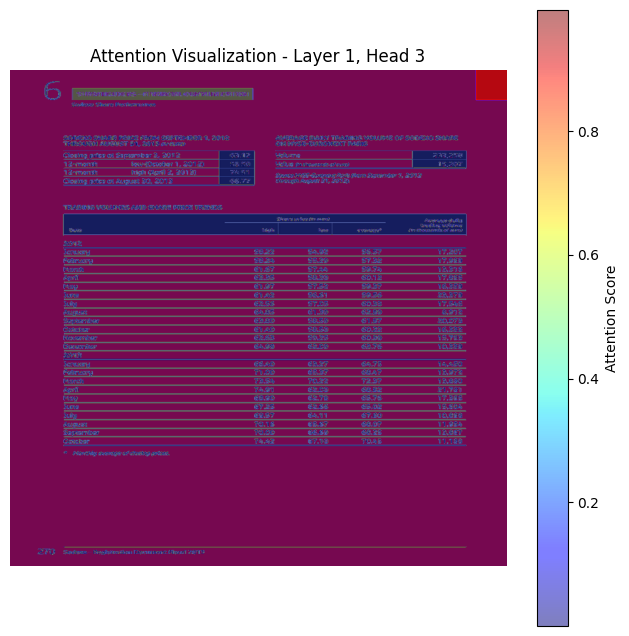

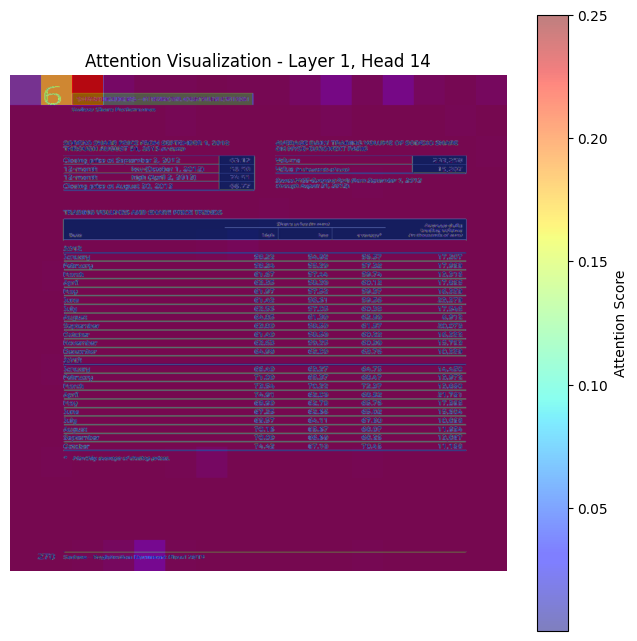

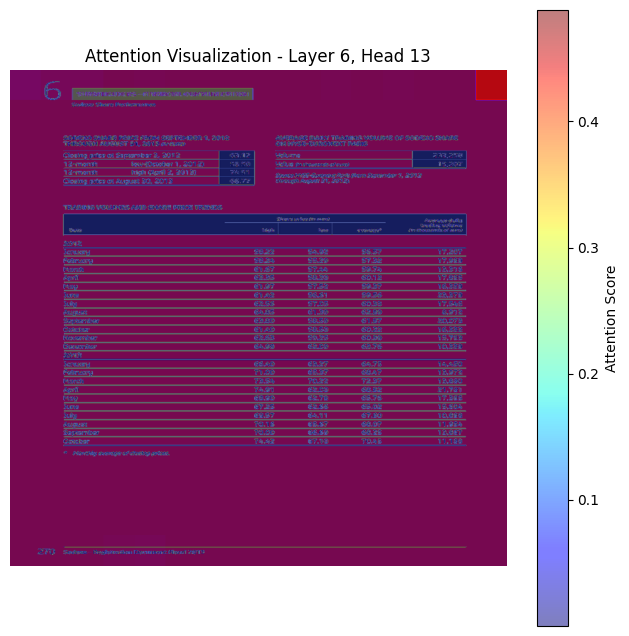

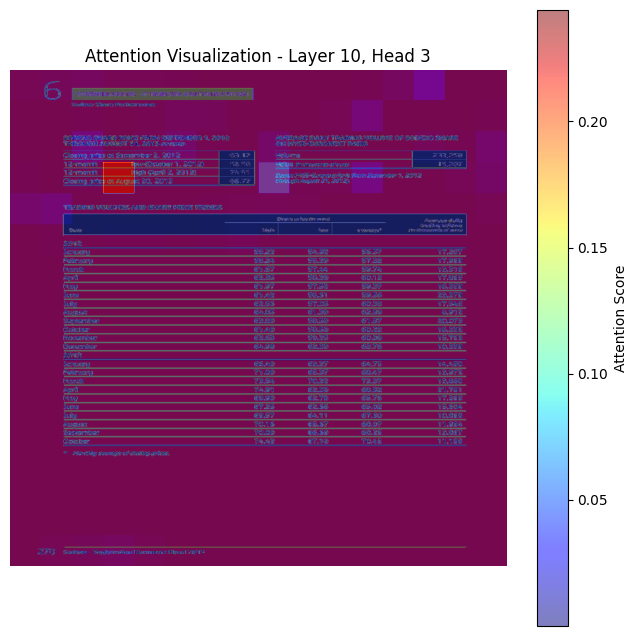

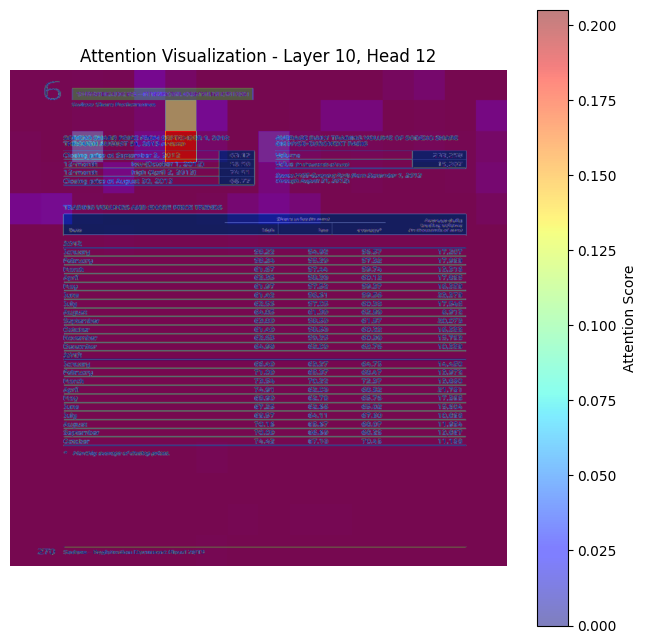

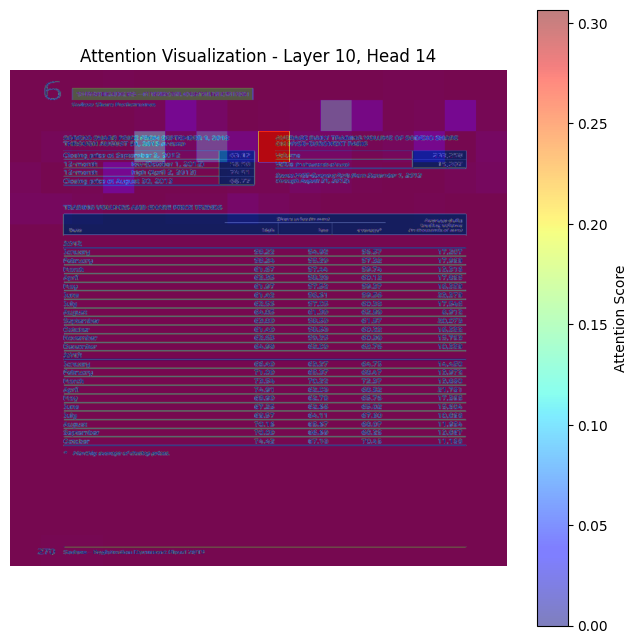

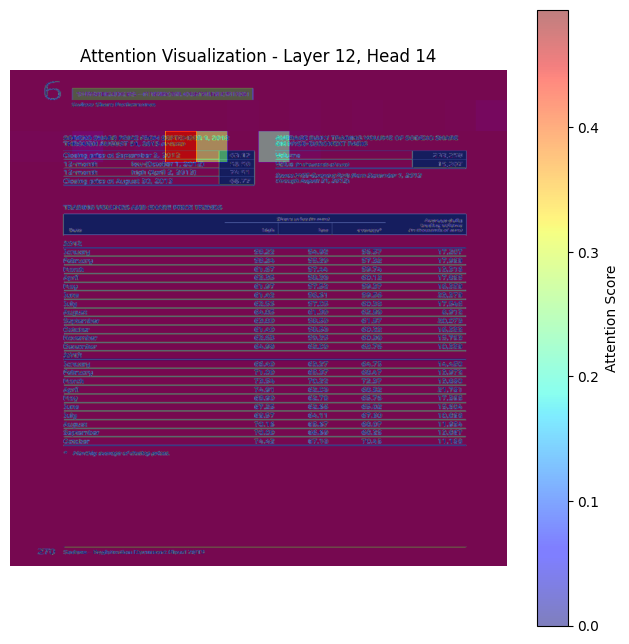

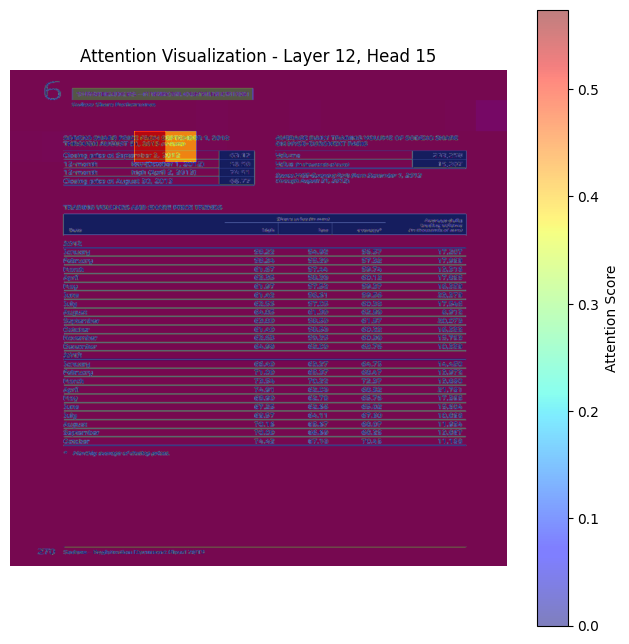

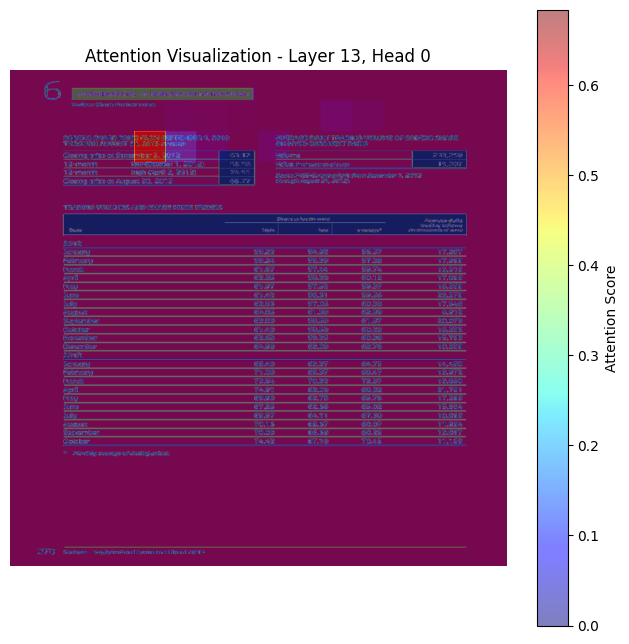

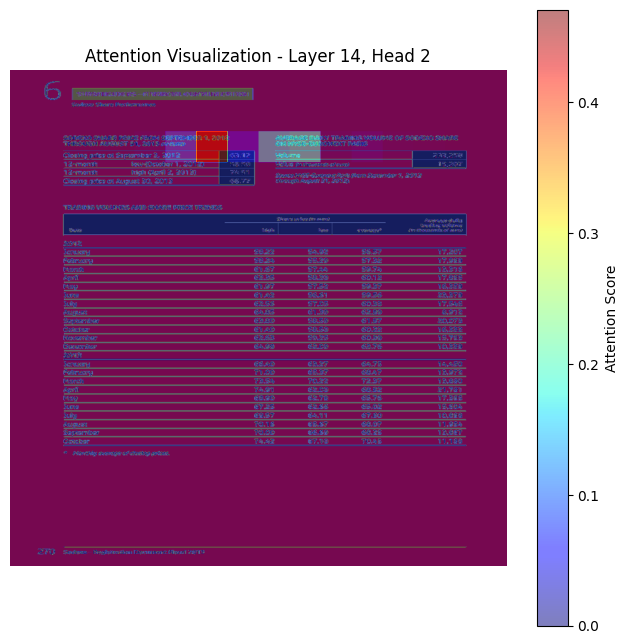

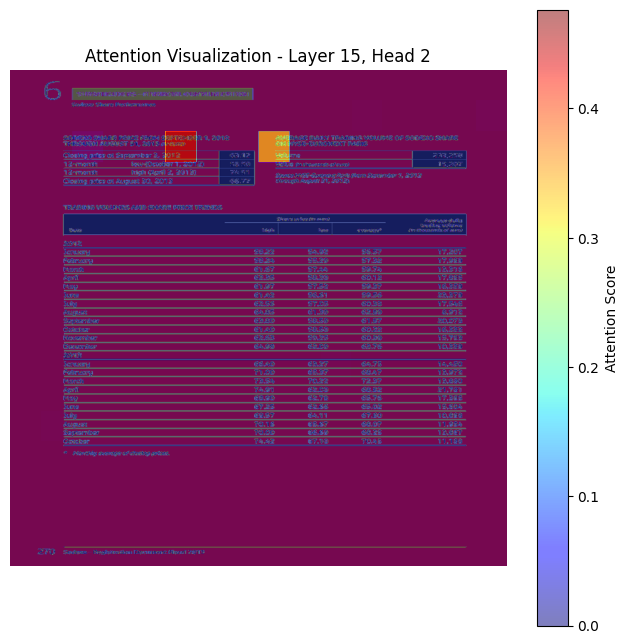

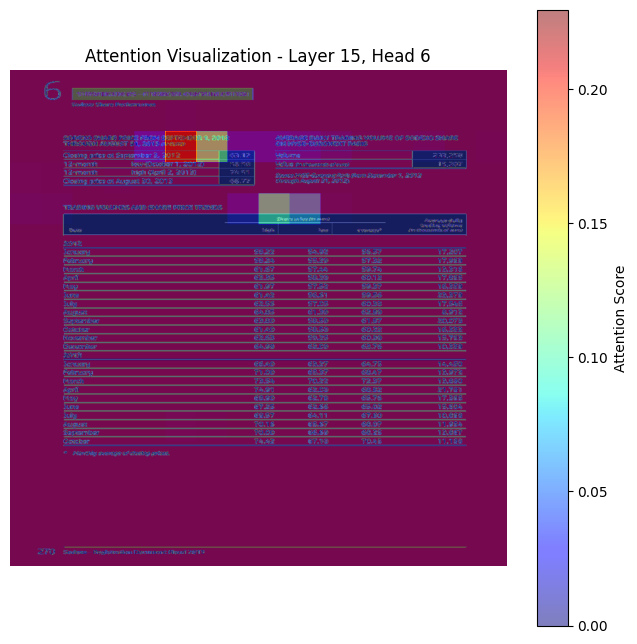

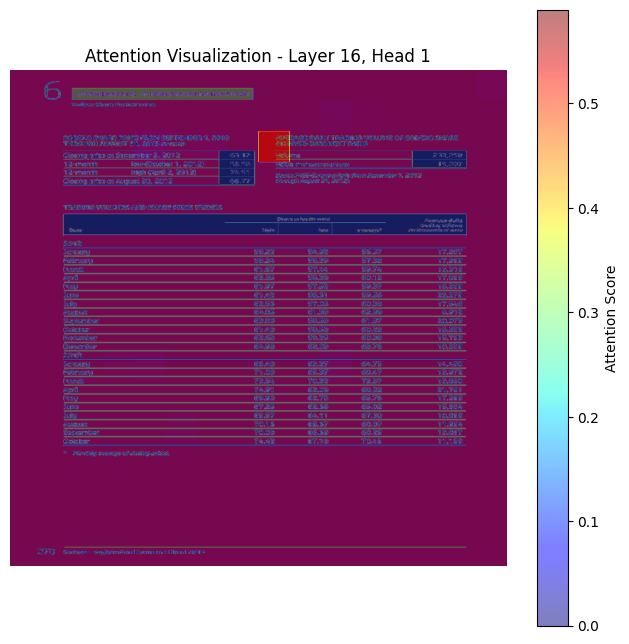

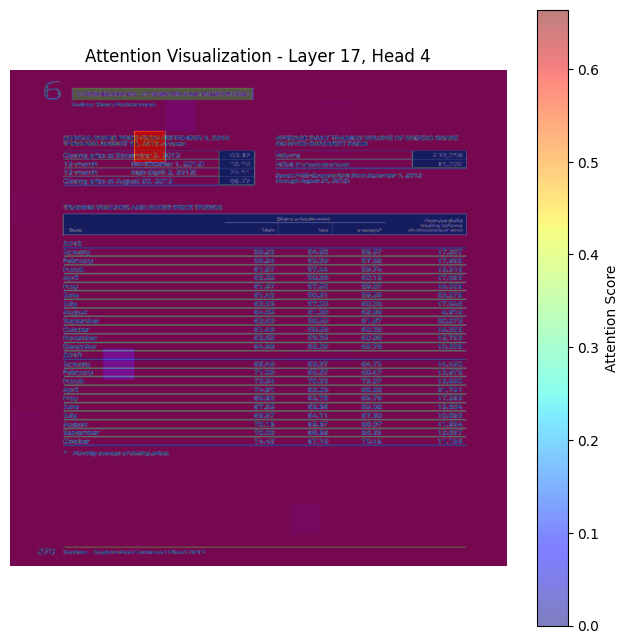

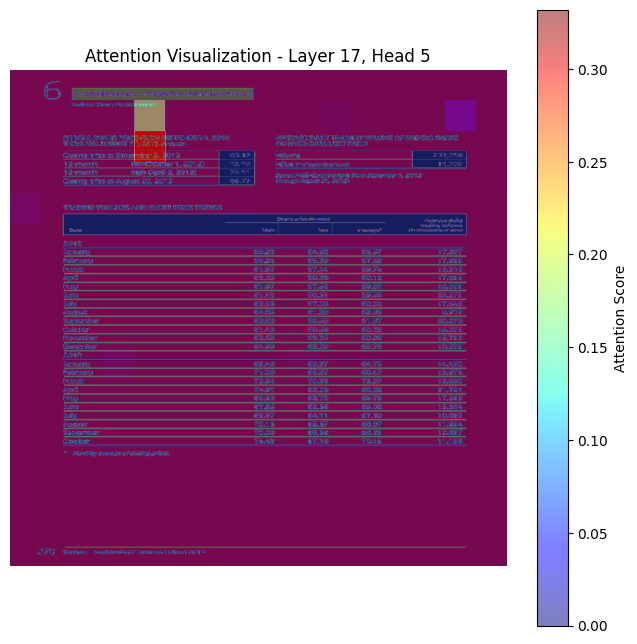

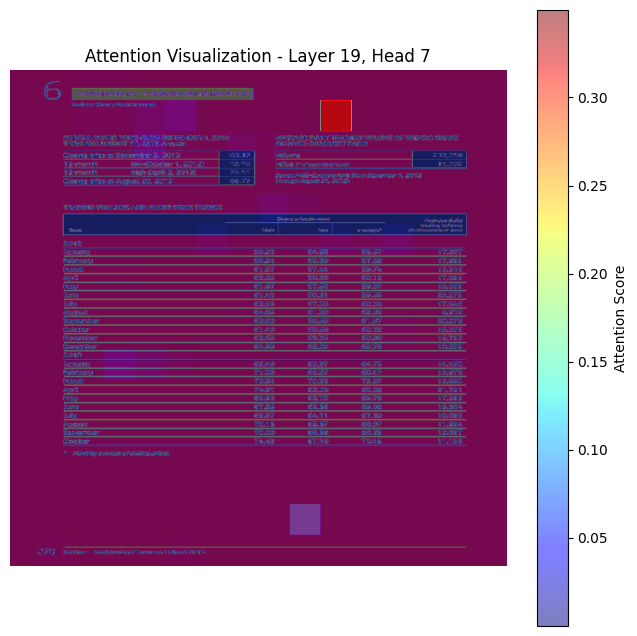

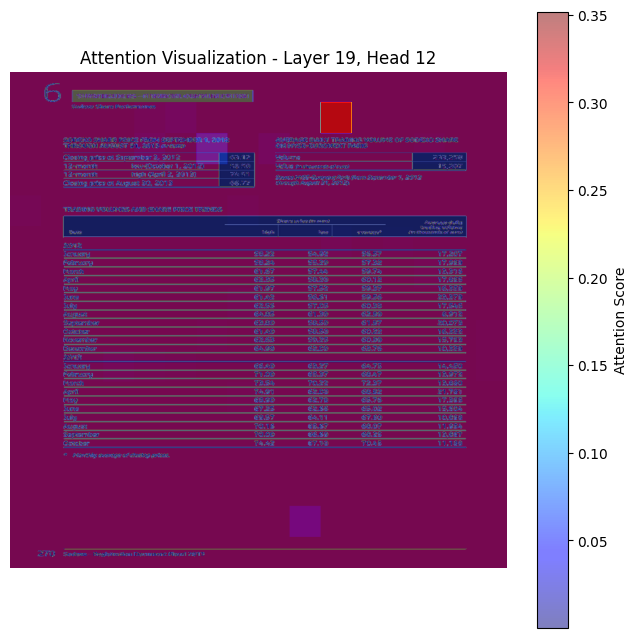

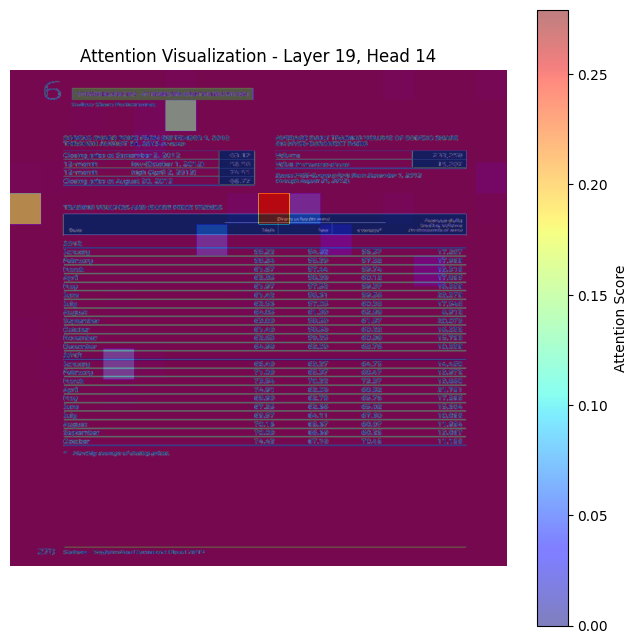

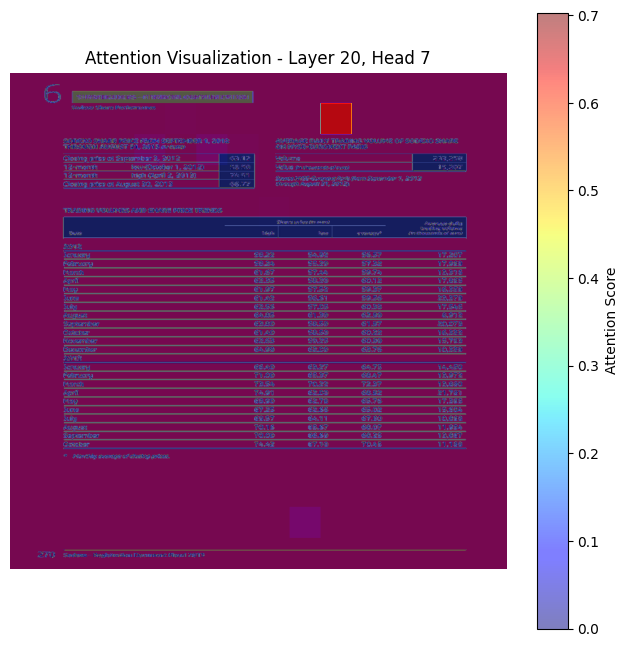

['1']
['system\nYou should follow the instructions carefully and explain your answers in detail.user\n\nPOD and OCR: assistant\n[66, 27, 479, 60] Page-header <content>66SHAREHOLDERS – FINANCIAL COMMUNICATION </content>\n[123, 65, 292, 79] Text <content>Sodexo Share Performance</content>\n[105, 130, 443, 158] Section-header <content>SODEXO SHARE PRICE FROM SEPTEMBER 1, 2012 THROUGH AUGUST 31, 2013 (IN EURO)</content>\n[531, 130, 905, 158] Section-header <content>AVERAGE DAILY TRADING VOLUME OF SODEXO SHARE ON NYSE-EURO NEXT PARIS</content>\n[1']


In [32]:
input_ids = torch.as_tensor(inputs.input_ids).cuda()
original_input_ids = input_ids.clone()
viz_id = 178
with torch.autocast("cuda", dtype=torch.bfloat16):
    attention_mask = torch.ones_like(input_ids).cuda()
    past_key_values = None
    use_cache = True
    for i in range(viz_id+1):
        outputs = model(
            input_ids,
            images=[image_tensor_1.unsqueeze(0).half().cuda()],
            attention_mask=attention_mask,
            position_ids=None,
            use_cache=use_cache,
            past_key_values=past_key_values,
            )
        hidden_states = outputs.hidden_states[-1][:,-1:, :]
        logits = model.lm_head(hidden_states)
        logits = logits.float()
        input_ids = logits.argmax(-1)
        original_input_ids = torch.cat((original_input_ids, input_ids), dim=-1)
        past_key_values = outputs.past_key_values
        attention_mask = torch.cat((attention_mask, torch.ones_like(input_ids)), dim=-1)

        if i == viz_id:
            for layer in range(24):
                for head in range(16):
                    visualize_attention_on_image(outputs.attentions, original_input_ids, 151859, image_tensor_1, layer=layer, head=head, threshold=0.2)

            output = tokenizer.batch_decode(input_ids, skip_special_tokens=True)
            print(output)

        # import seaborn as sns
        # import matplotlib.pyplot as plt

        # attention = outputs.attentions
        # scores, indices = outputs.attentions[-1][0,0,-1:].topk(10)
        # viz_input_ids = torch.tensor([original_input_ids[0][ind] for ind in indices[0]], device='cuda')
        # print(viz_input_ids)
        # attention_matrix = scores.to(torch.float16).detach().cpu().numpy()
        # # attention_matrix = outputs.attentions[-1][0,0,-1:].to(torch.float16).detach().cpu().numpy()

        # sns.heatmap(attention_matrix, xticklabels=tokenizer.convert_ids_to_tokens(viz_input_ids),
        #             yticklabels=tokenizer.convert_ids_to_tokens(input_ids[0]), cmap="viridis")
        # plt.title("Attention Weights")
        # plt.show()

        # output decoded tokens
        if input_ids[0, -1] == tokenizer.eos_token_id:
            break

    output = tokenizer.batch_decode(original_input_ids, skip_special_tokens=True)
    print(output)
        

In [6]:
special_token = 151859
special_token_index = (original_input_ids[0] == special_token).nonzero(as_tuple=True)[0]
outputs.attentions[-1][0,0,-1][special_token_index].shape

torch.Size([256])

In [11]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
from scipy.ndimage import zoom

def visualize_attention_on_image(
    attention, input_ids_, special_token, image_tensor, layer=0, head=0
):
    """
    可视化特定层和特定head的attention score在输入图片上的分布。
    
    Parameters:
    - attention: 模型的attention输出。
    - original_input_ids: 输入的token IDs。
    - special_token: 表示图片的特殊token ID。
    - image_tensor: 经过transform后的输入图像张量，形状为 (C, H, W)。
    - layer: 要可视化的层索引。
    - head: 要可视化的head索引。
    """
    # Step 1: 提取指定层和head的attention矩阵
    attention_scores = attention[layer][0]  # 提取第layer层，batch第0个的attention
    attention_scores = attention_scores[head][-1]  # 提取指定head的attention矩阵, shape: (n, )
    
    # Step 2: 找到 special_token 对应的index
    special_token_index = (input_ids_[0] == special_token).nonzero(as_tuple=True)[0]
    print(special_token_index.shape)
    
    # Step 3: 获取该token对之前所有tokens的attention score
    token_attention = attention_scores[special_token_index]  # shape: (n,)
    print(token_attention.shape)

    # Step 4: 将 token_attention 的图片部分reshape到 (16, 16)
    # 假设最后 16*16 个token 是图片token
    image_attention_16x16 = token_attention[-256:].reshape(1, 1, 16, 16)  # 形状为 (1, 1, 16, 16)

    # Step 5: 使用torch.nn.functional.interpolate将 (16, 16) 的attention score差值到 (1024, 1024)
    H, W = 1024, 1024
    image_attention_resized = F.interpolate(image_attention_16x16, size=(H, W), mode='bilinear', align_corners=False)
    image_attention_resized = image_attention_resized.squeeze().detach().to(torch.float16).cpu().numpy()  # 转换为numpy数组用于可视化

    # Step 6: 可视化attention score在图像上的热力图
    # 将image_tensor转换为可显示的格式
    img = transforms.ToPILImage()(image_tensor)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.imshow(image_attention_resized, cmap='jet', alpha=0.5)  # 使用alpha叠加热力图
    plt.colorbar(label="Attention Score")
    plt.title(f"Attention Visualization - Layer {layer}, Head {head}")
    plt.axis('off')
    plt.show()

# 示例调用
# visualize_attention_on_image(attention=outputs.attentions, original_input_ids[0], special_token=12345, image_tensor=image_tensor, layer=3, head=2)

torch.Size([256])
torch.Size([256])


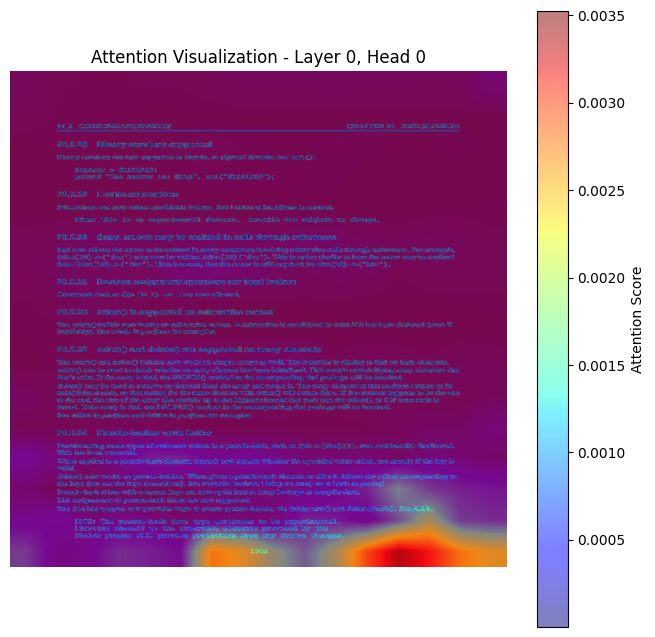

In [12]:
visualize_attention_on_image(outputs.attentions, original_input_ids, 151859, image_tensor_1, layer=0, head=0)

In [35]:
(original_input_ids[0] == special_token).nonzero(as_tuple=True)[0]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


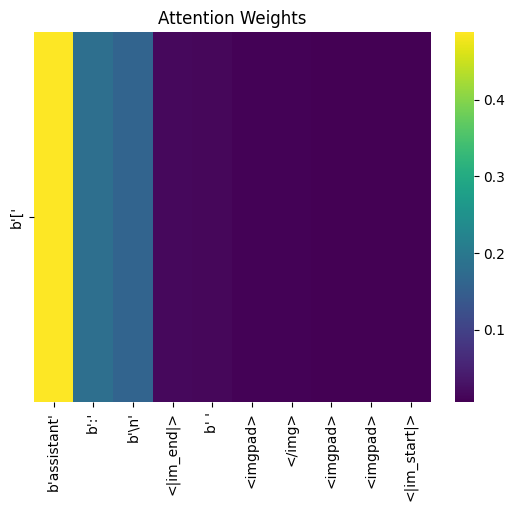

In [23]:
attention = outputs.attentions
scores, indices = outputs.attentions[-1][0,0,-1:].topk(10)
viz_input_ids = torch.tensor([original_input_ids[0][ind] for ind in indices[0]], device='cuda')
attention_matrix = scores.to(torch.float16).detach().cpu().numpy()
# attention_matrix = outputs.attentions[-1][0,0,-1:].to(torch.float16).detach().cpu().numpy()

sns.heatmap(attention_matrix, xticklabels=tokenizer.convert_ids_to_tokens(viz_input_ids),
            yticklabels=tokenizer.convert_ids_to_tokens(input_ids[0]), cmap="viridis")
plt.title("Attention Weights")
plt.show()

((tensor([[[[-1.1719e+00, -1.4941e-01, -2.5781e-01,  ..., -2.6719e+00,
              2.9062e+00, -4.7500e+00],
            [-7.1875e-01, -3.7109e-02, -1.2500e-01,  ..., -2.5781e+00,
              2.6250e+00, -4.5312e+00],
            [ 5.3711e-02, -1.4648e-01,  6.8359e-02,  ..., -2.4844e+00,
              2.7344e+00, -4.5312e+00],
            ...,
            [ 1.2188e+00,  9.0332e-02,  6.4941e-02,  ..., -2.6719e+00,
              2.9062e+00, -4.7500e+00],
            [-4.0234e-01, -3.0273e-02, -1.3794e-02,  ..., -2.6875e+00,
              2.7969e+00, -4.5938e+00],
            [ 2.5391e-02,  2.4512e-01, -1.7578e-02,  ..., -2.4844e+00,
              2.7344e+00, -4.5312e+00]],
  
           [[-3.1375e+01,  2.4000e+01,  1.4375e+01,  ..., -2.2750e+01,
             -1.3812e+01, -1.4500e+01],
            [ 1.1625e+01,  2.9250e+01,  1.6500e+01,  ..., -2.2625e+01,
             -1.3500e+01, -1.4312e+01],
            [ 4.2750e+01,  2.2750e+01,  1.4250e+01,  ..., -2.3125e+01,
             -1.4062